In [1]:
import os
import numpy as np
from functools import partial
import math
from tqdm import tqdm
import time as time

import torch
M1 = False

if M1:
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
else:
    os.environ["CUDA_VISIBLE_DEVICES"]="2"
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if torch.cuda.is_available():
        print(torch.cuda.is_available())
        print(torch.cuda.device_count())
        print(torch.cuda.current_device())
        print(torch.cuda.get_device_name(torch.cuda.current_device()))

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches
import matplotlib.ticker as tick


import scipy as sp
import large_scale_UQ as luq
from large_scale_UQ.utils import to_numpy, to_tensor



True
1
0
NVIDIA A100-PCIE-40GB
Using device: cuda


In [2]:
# Save param
repo_dir = '/disk/xray0/tl3/repos/large-scale-UQ'

# save_dir = '/disk/xray0/tl3/outputs/large-scale-UQ/def_UQ_results/wavelets/hypothesis_test_paper_figs/'
# load_var_dir = '/disk/xray0/tl3/outputs/large-scale-UQ/def_UQ_results/wavelets/vars/'

save_dir = '/disk/xray0/tl3/outputs/large-scale-UQ/def_UQ_results/v2/wavelets/hypothesis_test_paper_figs/'
load_var_dir = '/disk/xray99/tl3/proj-convex-UQ/outputs/new_UQ_results/wavelets/vars/'


# Confidence value
alpha_prob = 0.01
# Blurring Gaussian St Dev
G_sigma = 3.5 # 1.02

# Inpatinting params
inptaint_options = {
    "tol": 5e-6,
    "iter": 15000,
    "update_iter": 4999,
    "record_iters": False
}

map_potential_list = []
likelihood_map_potential_list = []
prior_map_potential_list = []
surrogate_potential_list = []
likelihood_surrogate_potential_list = []
prior_surrogate_potential_list = []
gamma_alpha_list = []
Hnot_reject_list = []
potential_blurring_list = []
Hnot_reject_blurring_list = []
SNR_list = []
PSNR_list = []

cmap = 'cubehelix'
model_prefix = '-WAV'
input_snr = 30.
cbar_font_size = 18
box_font_size = 18

# Wavelet parameters
# reg_param = 1e4  # 5e2 #
wavs_list = ['db8']
levels = 4

map_vars_path_arr = [
    load_var_dir+'CYN_wavelets_UQ_MAP_reg_param_5.0e+02_MAP_vars.npy',
    load_var_dir+'M31_wavelets_UQ_MAP_reg_param_5.0e+02_MAP_vars.npy',
    load_var_dir+'3c288_wavelets_UQ_MAP_reg_param_5.0e+02_MAP_vars.npy',
    load_var_dir+'3c288_wavelets_UQ_MAP_reg_param_5.0e+02_MAP_vars.npy',
    load_var_dir+'W28_wavelets_UQ_MAP_reg_param_5.0e+02_MAP_vars.npy',
]
samp_vars_path_arr = [
    load_var_dir+'CYN_SKROCK_wavelets_reg_param_5.0e+02_nsamples_5.0e+04_thinning_1.0e+01_vars.npy',
    load_var_dir+'M31_SKROCK_wavelets_reg_param_5.0e+02_nsamples_5.0e+04_thinning_1.0e+01_vars.npy',
    load_var_dir+'3c288_SKROCK_wavelets_reg_param_5.0e+02_nsamples_5.0e+04_thinning_1.0e+01_vars.npy',
    load_var_dir+'3c288_SKROCK_wavelets_reg_param_5.0e+02_nsamples_5.0e+04_thinning_1.0e+01_vars.npy',
    load_var_dir+'W28_SKROCK_wavelets_reg_param_5.0e+02_nsamples_5.0e+04_thinning_1.0e+01_vars.npy',    
]
img_name_list = ['CYN', 'M31', '3c288', '3c288','W28']
pysiscal_list = [True, True, True, False, True]
vmin_log_arr = [-3., -2., -2., -2., -2.]
text_str_arr = [r'$1$',r'$1$',r'$1$',r'$2$',r'$1$']
saving_text_str_arr = ['1', '1', '1', '2', '1']
text_pos_arr = [
    [0, 0.12],
    [0, 0.06],
    [0, 0.06],
    [-0.05, -0.01],
    [0, 0.06],
]


save_results = False

reg_param_list = np.logspace(np.log10(1), np.log10(5e4), num=30, endpoint=True, base=10.0)
reg_param_list[0] = 7e1 
reg_param_list[1] = 8e1 
reg_param_list[2] = 9e1
reg_param_list[3] = 1e2
reg_param_list[4] = 1.1e2
reg_param_list[25] = 1e4



In [3]:
reg_param_list

array([7.00000000e+01, 8.00000000e+01, 9.00000000e+01, 1.00000000e+02,
       1.10000000e+02, 6.45902911e+00, 9.37995361e+00, 1.36217887e+01,
       1.97818811e+01, 2.87277118e+01, 4.17190571e+01, 6.05853935e+01,
       8.79835297e+01, 1.27771746e+02, 1.85553127e+02, 2.69464604e+02,
       3.91322820e+02, 5.68288180e+02, 8.25281427e+02, 1.19849305e+03,
       1.74047972e+03, 2.52756549e+03, 3.67058990e+03, 5.33051677e+03,
       7.74110151e+03, 1.00000000e+04, 1.63256191e+04, 2.37084470e+04,
       3.44299630e+04, 5.00000000e+04])

Threshold:  0.0002998184652599583
Running Base Forward Backward
[Forward Backward] 0 out of 500 iterations, tol = 3.67e-01
[Forward Backward] converged in 415 iterations

MAP reg_param:  200.0
Image:  CYN
PSNR: 57.17,
 SNR: 22.33, SSIM: 0.99


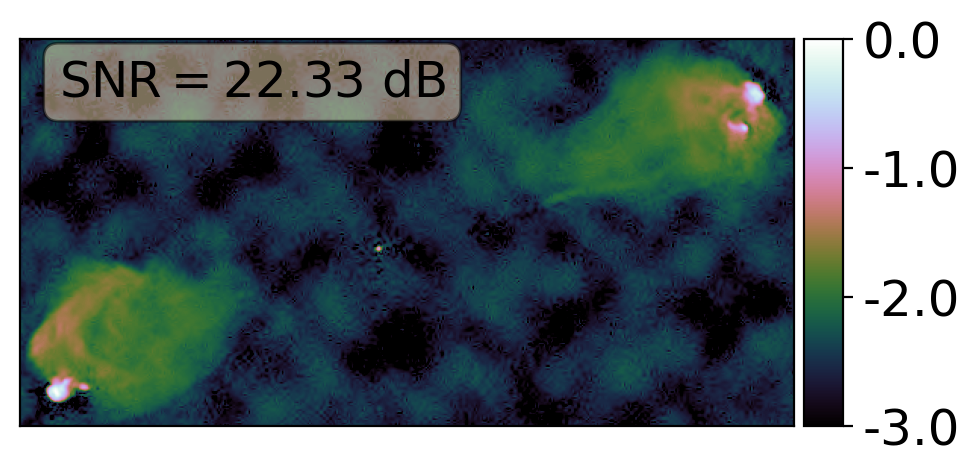

gamma_alpha:  219384.04785888284
fun(x_map).item():  84853.47896058254
tau_alpha*np.sqrt(N) + N:  134530.56889830032
CYN _gamma_alpha:  219384.04785888284
CYN -MAP_potential:  84853.47896058254
Threshold:  0.005772466038755327
Running Base Forward Backward
[Forward Backward] 0 out of 500 iterations, tol = 4.01e-01
[Forward Backward] converged in 88 iterations

MAP reg_param:  200.0
Image:  M31
PSNR: 46.38,
 SNR: 23.94, SSIM: 0.98


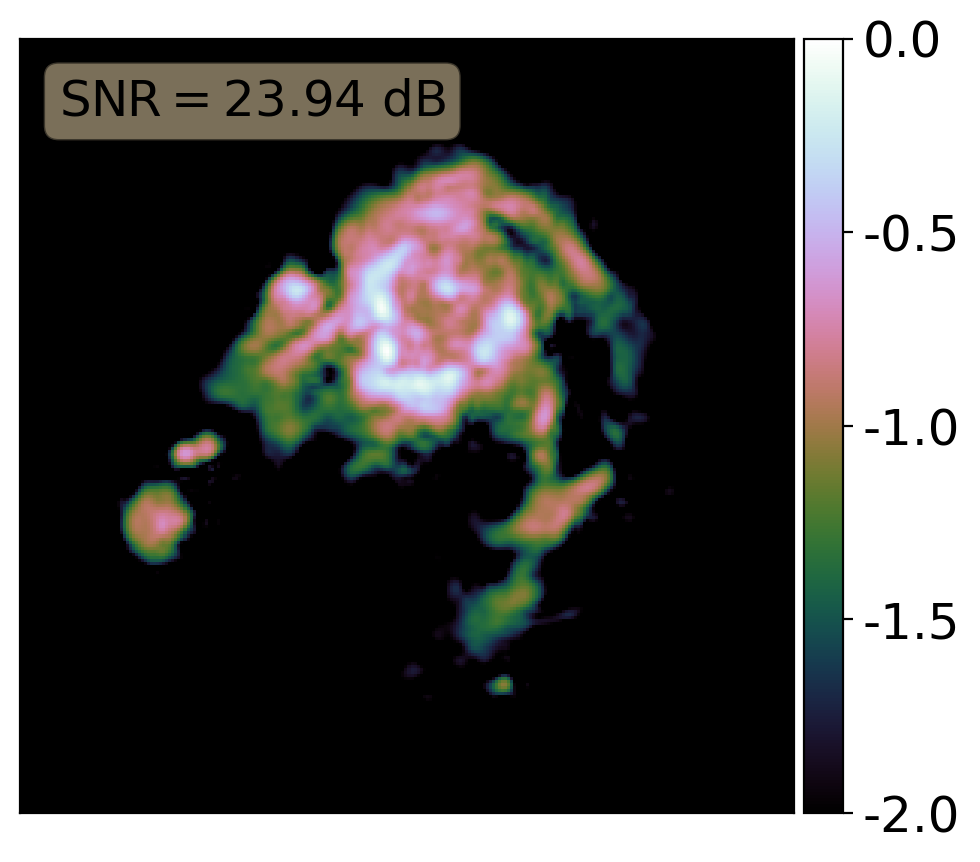

gamma_alpha:  132952.15977367252
fun(x_map).item():  64970.58225248349
tau_alpha*np.sqrt(N) + N:  67981.57752118903
M31 _gamma_alpha:  132952.15977367252
M31 -MAP_potential:  64970.58225248349
Threshold:  0.006840733505111962
Running Base Forward Backward
[Forward Backward] 0 out of 500 iterations, tol = 2.57e-01

MAP reg_param:  200.0
Image:  3c288
PSNR: 36.54,
 SNR: 13.84, SSIM: 0.83


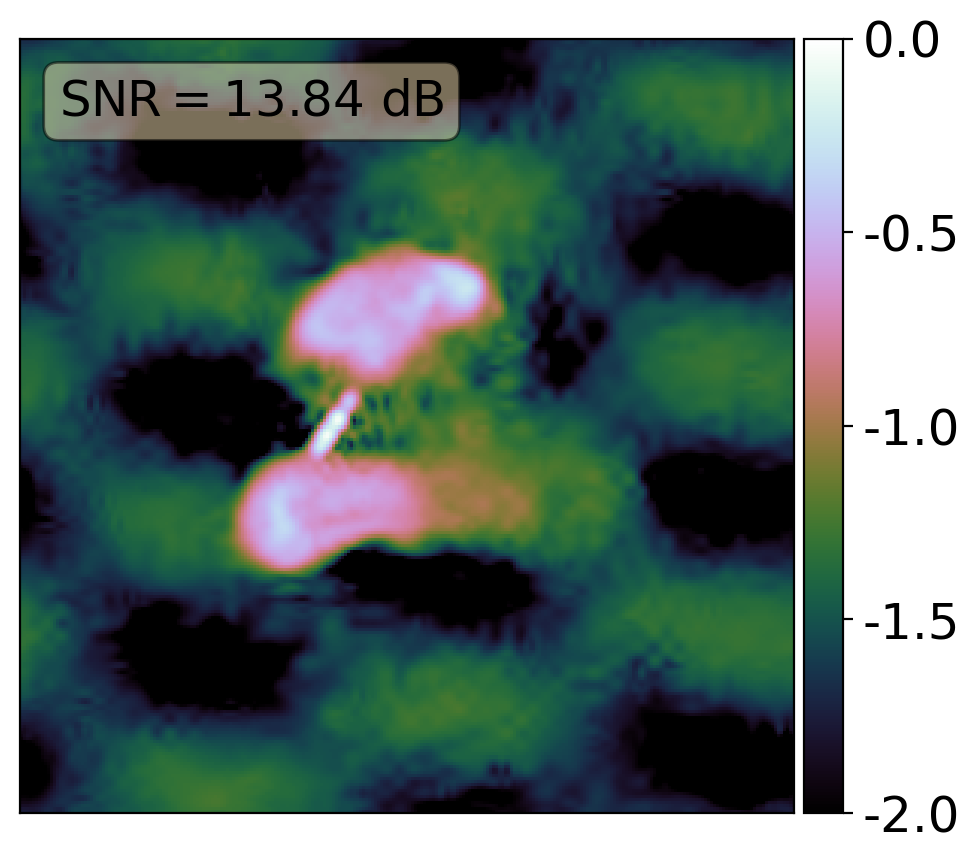

gamma_alpha:  188676.84705289314
fun(x_map).item():  120695.26953170412
tau_alpha*np.sqrt(N) + N:  67981.57752118903
3c288 _gamma_alpha:  188676.84705289314
3c288 -MAP_potential:  120695.26953170412
Threshold:  0.006840733505111962
Running Base Forward Backward
[Forward Backward] 0 out of 500 iterations, tol = 2.57e-01

MAP reg_param:  200.0
Image:  3c288
PSNR: 36.54,
 SNR: 13.84, SSIM: 0.83


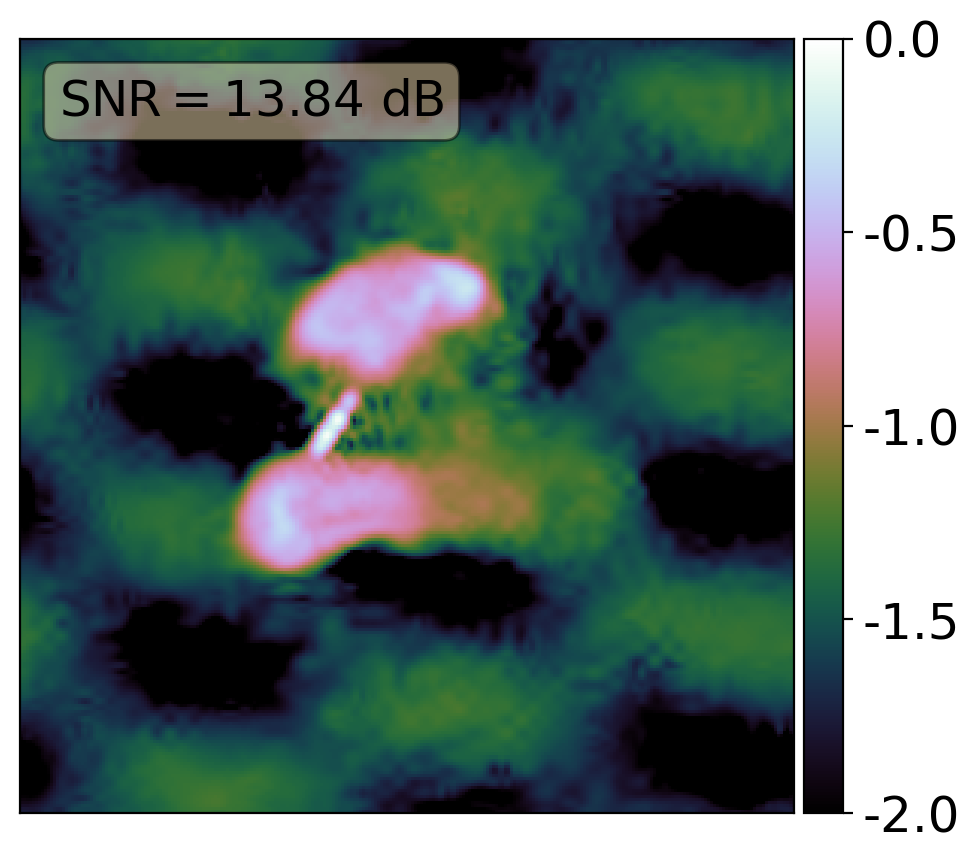

gamma_alpha:  188676.84705289314
fun(x_map).item():  120695.26953170412
tau_alpha*np.sqrt(N) + N:  67981.57752118903
3c288 _gamma_alpha:  188676.84705289314
3c288 -MAP_potential:  120695.26953170412
Threshold:  0.0010399611785865102
Running Base Forward Backward
[Forward Backward] 0 out of 500 iterations, tol = 5.22e-01
[Forward Backward] converged in 212 iterations

MAP reg_param:  200.0
Image:  W28
PSNR: 51.72,
 SNR: 22.87, SSIM: 0.99


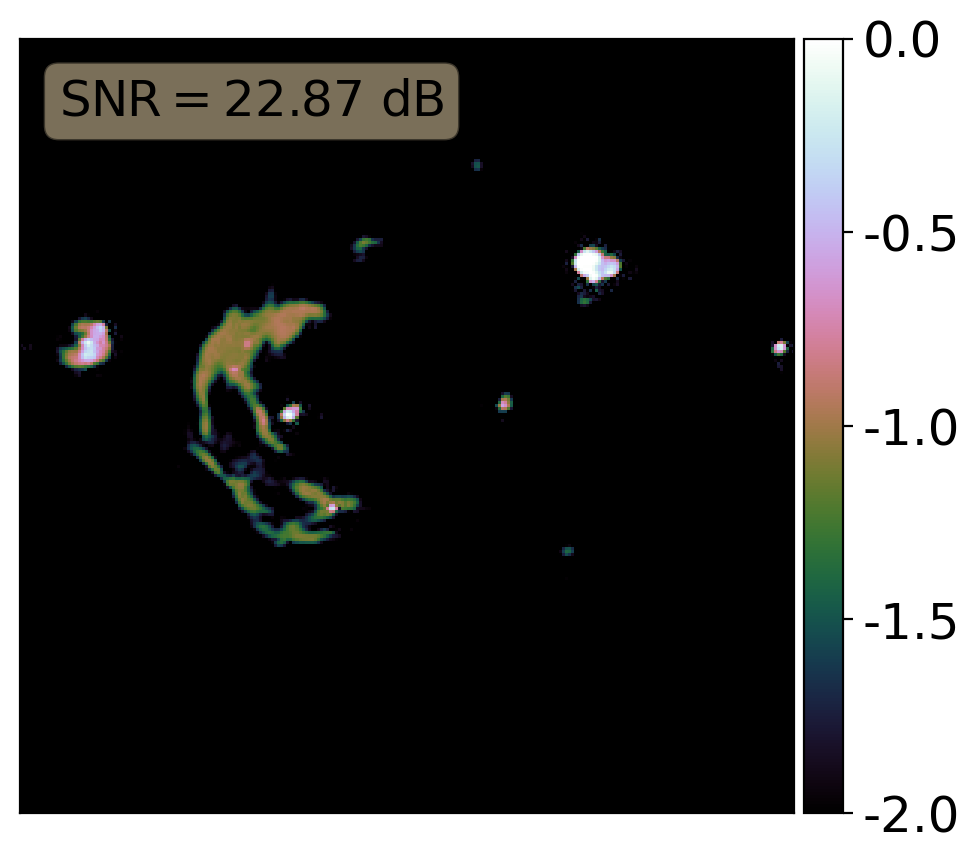

gamma_alpha:  121864.9360120031
fun(x_map).item():  53883.35849081406
tau_alpha*np.sqrt(N) + N:  67981.57752118903
W28 _gamma_alpha:  121864.9360120031
W28 -MAP_potential:  53883.35849081406


In [5]:

for it_img in range(len(img_name_list)):

# for reg_param in reg_param_list:

    reg_param = 2e2
    # it_img = 1  # M31
    img_name = img_name_list[it_img]
    map_vars_path = map_vars_path_arr[it_img]
    samp_vars_path = samp_vars_path_arr[it_img]
    vmin_log = vmin_log_arr[it_img]

    text_pos = text_pos_arr[it_img]
    textstr = text_str_arr[it_img]
    saving_text_str = saving_text_str_arr[it_img]

    # Load variables
    map_vars = np.load(map_vars_path, allow_pickle=True)[()]
    samp_vars = np.load(samp_vars_path, allow_pickle=True)[()]

    # Load image and mask
    img, mat_mask = luq.helpers.load_imgs(img_name, repo_dir)

    # Define my torch types
    myType = torch.float64
    myComplexType = torch.complex128


    # Aliases
    x = img
    ground_truth = img
    # Prepare inputs and functions
    torch_img = torch.tensor(
        np.copy(img), dtype=myType, device=device).reshape((1,1) + img.shape
    )
    phi = luq.operators.MaskedFourier_torch(
        shape=img.shape, 
        ratio=0.5 ,
        mask=mat_mask,
        norm='ortho',
        device=device
    )
    y = phi.dir_op(torch_img).detach().cpu().squeeze().numpy()

    # Define X Cai noise level
    eff_sigma = luq.helpers.compute_complex_sigma_noise(y, input_snr)
    sigma = eff_sigma * np.sqrt(2)

    # Generate noise
    rng = np.random.default_rng(seed=0)
    n_re = rng.normal(0, eff_sigma, y[y!=0].shape)
    n_im = rng.normal(0, eff_sigma, y[y!=0].shape)
    # Add noise
    y[y!=0] += (n_re + 1.j*n_im)

    # Observation
    torch_y = torch.tensor(np.copy(y), device=device, dtype=myComplexType).reshape((1,) + img.shape)
    x_init = torch.abs(phi.adj_op(torch_y))

    # %%
    # Define the likelihood
    g = luq.operators.L2Norm_torch(
        sigma=sigma,
        data=torch_y,
        Phi=phi,
    )
    # Lipschitz constant computed automatically by g, stored in g.beta

    # Define real prox
    f = luq.operators.RealProx_torch()


    # Define the wavelet dict
    # Define the l1 norm with dict psi
    psi = luq.operators.DictionaryWv_torch(wavs_list, levels)
    h = luq.operators.L1Norm_torch(1., psi, op_to_coeffs=True)
    # Prior parameter
    h.gamma = reg_param


    # Compute stepsize
    alpha = 0.98 / g.beta

    # Effective threshold
    print('Threshold: ', h.gamma * alpha)

    # Optimisation options for the MAP estimation
    options = {"tol": 1e-4, "iter": 500, "update_iter": 4999, "record_iters": False}
    # options = {"tol": 1e-5, "iter": 15000, "update_iter": 4999, "record_iters": False}

    # Run the optimisation
    x_hat, diagnostics = luq.optim.FB_torch(
        x_init,
        options=options,
        g=g,
        f=f,
        h=h,
        alpha=alpha,
        tau=alpha,
        viewer=None
    )

    # %%
    np_x_init = to_numpy(x_init)
    np_x = np.copy(x)
    np_x_hat = to_numpy(x_hat)


    print('\nMAP reg_param: ', reg_param)
    print('Image: ', img_name)
    print('PSNR: {},\n SNR: {}, SSIM: {}'.format(
        round(psnr(np_x, np_x_hat, data_range=np_x.max()-np_x.min()), 2),
        round(luq.utils.eval_snr(np_x, np_x_hat), 2),
        round(ssim(np_x, np_x_hat, data_range=np_x.max()-np_x.min()), 2),
    ))

    SNR_list.append(luq.utils.eval_snr(np_x, np_x_hat))
    PSNR_list.append(psnr(np_x, np_x_hat, data_range=np_x.max()-np_x.min()))


    # Extract variables
    x_gt = np.copy(x) #  samp_vars['X_ground_truth']
    x_dirty = np.copy(np_x_init)  # samp_vars['X_dirty']
    x_map = np.copy(np_x_hat)  # samp_vars['X_MAP']



    # Compute SNR
    map_snr = luq.utils.eval_snr(x_gt, x_map)
    # Plot MAP
    fig = plt.figure(figsize=(5,5), dpi=200)
    axs = plt.gca()
    plt_im = axs.imshow(np.log10(np.abs(x_map)), cmap=cmap, vmin=vmin_log, vmax=0)
    divider = make_axes_locatable(axs)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(plt_im, cax=cax)
    cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.1f'))
    cbar.ax.tick_params(labelsize=cbar_font_size)
    axs.set_yticks([]);axs.set_xticks([])
    textstr = r'$\mathrm{SNR}=%.2f$ dB'%(np.mean(map_snr))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    axs.text(
        0.05, 0.95, textstr, transform=axs.transAxes,
        fontsize=box_font_size, verticalalignment='top', bbox=props
    )
    plt.tight_layout()
    plt.show()


    # To tensor
    x_map_torch = to_tensor(x_map)

    # Compute stepsize
    alpha = 0.98 / g.beta

    x_map_torch = to_tensor(x_map)


    #function handles for the hypothesis test

    # Evaluation of the potentials
    # Prior potential
    prior_fun = lambda _x : h._fun_coeffs(h.dir_op(_x))
    # Posterior potential
    fun = lambda _x : g.fun(_x) +  prior_fun(_x)
    # Evaluation of the potential in numpy
    fun_np = lambda _x : fun(to_tensor(_x, dtype=myType)).item()

    # Compute HPD region bound
    N = x_map.size
    tau_alpha = np.sqrt(16*np.log(3/alpha_prob))
    gamma_alpha = fun(x_map_torch).item() + tau_alpha*np.sqrt(N) + N

    print('gamma_alpha: ', gamma_alpha)
    print('fun(x_map).item(): ', fun(x_map_torch).item())
    print('tau_alpha*np.sqrt(N) + N: ', tau_alpha*np.sqrt(N) + N)

    # Compute potential
    map_potential = fun(x_map_torch).item()

    # Decompose potentials
    map_likelihood_potential = g.fun(x_map_torch).item()
    map_prior_potential = prior_fun(x_map_torch).item()

    # Print values
    print(img_name, '_gamma_alpha: ', gamma_alpha)
    print(img_name, '-MAP_potential: ', map_potential)
    # Save values
    map_potential_list.append(map_potential)
    gamma_alpha_list.append(gamma_alpha)

    # Save decomposed potentials
    likelihood_map_potential_list.append(map_likelihood_potential)
    prior_map_potential_list.append(map_prior_potential)




save_dict = {
    'alpha_prob': alpha_prob,
    'reg_param_list': reg_param_list,
    'SNR_list': SNR_list,
    'PSNR_list': PSNR_list,
    'map_potential_list': map_potential_list,
    'likelihood_map_potential_list': likelihood_map_potential_list,
    'prior_map_potential_list': prior_map_potential_list,
    'optim_options': options,
}


# Save variables
# if save_results:
try:
    save_path = '{:s}{:s}{:s}{:s}'.format(
        save_dir, 'test_reg_stregth', model_prefix, '_vars.npy'
    )
    if os.path.isfile(save_path):
        os.remove(save_path)
    np.save(save_path, save_dict, allow_pickle=True)

except Exception as e:
    print('Could not save vairables. Exception caught: ', e)


